# Colloid



This is a simple implementation of CPPNs(Composite Pattern Producing Networks) to produce abstract art patterns.This notebook walks you through the code involved to achieve the same. At the end I have written a piece of code which generates an animation of these patterns morphing and changing continuously, giving the feeling of mixing paint solutions, and hence the name Colloid.


Let's get started with the code-

#### Necessary Imports

* In this implementation I have not used any framework for CPNN architecture(vanilla NN structure), rather, I have hand coded it using Numpy library.
* CV2 and matplotlib are used mainly to perform image related operations like display image, create animation

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc 
import cv2
from pylab import *
import matplotlib.animation as animation

# from PIL import image

#### Architecture


architecture shit




#### Define activation functions-
These will be needed in the forward pass of NN.

In [9]:
#Sigmoid activation function
def sigmoid(z):
    temp = 1/(1+ np.exp(-z))
    return temp

In [12]:
#Relu activation function

def relu(z):
    temp = (z>0).astype('uint8')*z
    return temp

#### Define a function to Initialize NN parameters-





In [13]:
def initialize_parameters(input_dim, layer_dims):
    '''
    input_dim: integer, number of units in the input vector to the NN.
    layer_dims: list, number of units in each hidden layer of NN(in a ordered fashion)
    
    returns
    parameters: python dictionary, containing parameters of each hidden layer.
    '''
    
    L = len(layer_dims)  #number of hidden layers
    parameters={}
    
    for l in range(L):
        if l==0: 
            parameters['W' + str(l+1)] = np.random.randn(layer_dims[l], input_dim)
            parameters['b' + str(l+1)] = np.random.randn(layer_dims[l], 1)
        else:
            parameters['W' + str(l+1)] = np.random.randn(layer_dims[l], layer_dims[l-1])
            parameters['b' + str(l+1)] = np.random.randn(layer_dims[l], 1)
            
    assert len(parameters) == 2*L
    
    #parameters["W1"] is the weight matrix corresponding to 1st hidden layer.
    #paramters["b1"] is the bias matrix corresponding to 1st hidden layer.
    return parameters

#### Function to generate vectorized input matrix
Since, vectorized implementation cuts down the number of calculations involved, I am giving all input vectors corresonding to an image(one vector for each pixel cordinate) stacked as columns of a matrix(input matrix). The following function helps to generate that matrix provided the size of the output image.


In [14]:
def give_X(sizes, z):
    
    '''
    inputs-
    sizes:list, pixel dimension of output image (=~[x,y])
    z: latent space vector
    
    returns-
    final: matrix, to be used as the input to NN. 
    '''
    x= sizes[0]
    y= sizes[1]
    
    tempx = 2*np.dot(np.ones((y,1)),np.arange(x).reshape(1,x)-x//2)/(x-1)
    tempy = 2*np.dot(np.ones((x,1)),np.arange(y).reshape(1,y)-y//2).T/(y-1)
    
    #possible speedup here-
    radius = np.power(np.power(tempx,2)+ np.power(tempy,2),0.5)

    assert tempx.shape==(y,x)
    
    final = np.concatenate((tempx.reshape(1,x*y), tempy.reshape(1,x*y)), axis=0)
    final = np.concatenate((np.dot(z,np.ones((1, x*y))), final), axis=0)
    final = np.concatenate((final, radius.reshape(1, x*y)), axis=0)
    final = np.concatenate((final, np.ones((1, x*y))), axis=0)
    assert final.shape==(z.shape[0]+4, x*y) #input matrix has shape==(input_dims, x*y) where input_dims in the number of units in the input layer of NN.
    return final

#### Single step of feed forward

The following function implements a forward pass through a single hiddden layer of NN given layer parameters and activations from previous layer.

In [15]:
def step_forward(prev_a, W, b, activation):
    '''
    inputs-
    prev_a: matrix, activations from previous layer.
    W: matrix, weight for current hidden layer through which the forward pass has to be done.
    b: matrix, bias for current hidden layer through which the forward pass has to be done.
    activation: string, activation to be performed for current hidden layer.
    
    returns-
    next_a: matrix, activations from this hidden layer.
    '''
    
    temp = np.dot(W, prev_a) + b
    
    assert temp.shape == (W.shape[0], prev_a.shape[1])
    if activation == 'relu':
        next_a = relu(temp)
    
    elif activation == 'sigmoid':
        next_a = sigmoid(temp)
        
    elif activation == 'tanh':
        next_a = np.tanh(temp)
     
    return next_a

#### Forward pass through all layers

The following fuction implements feed forward through the entire NN. In this example I have chosen 'tanh' as activation for intermediate hidden layers and sigmoid for the final (output) hidden layer. These can be experimented with other activations such as sin, relu, gaussian to get different results.

##### Note:
Before the forward pass, the inputs are scaled. There are three scaling factors namely, 
* cord_scale: both cordinates in the vector are scaled by this factor .
* r_scale: radius in the input vector is scaled by this factor.
* z_scale: all entries of the latent space vector in the input vector are scale by this factor.

One can play with the kind of patterns produced by changing these scaling factors. This is also shown later in this notebook.

In [16]:
def feed_forward(X, parameters, cord_scale, r_scale, z_scale):
    '''
    X: matrix, the input matrix corresponding to an image.
    parameters: python dictionary, contains parameters(weights and biases) of the NN hidden layers.
    cord_scale: float, Cordinate scaling factor
    r_scale: float, radius scaling factor
    z_scale: float, latent space vector scaling scalar.
    
    returns-
    Y: matrix, each column represents pixel intensity of the output image. shape-(1, number_of_pixels) for greyscale and (3, number_of_pixels) for RGB
    '''
    L = len(parameters)//2            # number of hidden layers
    
    prev_a = X*(np.concatenate((np.ones((32,1))*z_scale, np.array([cord_scale, cord_scale, r_scale, 1]).reshape(4,1)),axis=0))
    
    
    
    for l in range(L-1):
        prev_a = step_forward(prev_a, parameters['W' +str(l+1)], parameters['b' + str(l+1)], 'tanh')
    
    Y = step_forward(prev_a, parameters['W' + str(L)], parameters['b' +str(L)], 'sigmoid')
    
    # assert Y.shape == (1, X.shape[1])
    
    return Y

#### Image-Generator funtion 
This function integrates all functions above. This is the fuction which is called by the user providing proper arguments.
##### Note: colored argument can be set to True, which will generate colored image else greyscale image is generated.

In [17]:
def image_gen(sizes, parameters, z, cord_scale, r_scale, z_scale, colored =False):
    '''
    inputs-
    sizes:list, desired pixel dimensions of the output image
    parameters: python dictionary, contains parameters of the NN.
    cord_scale: float, Cordinate scaling factor
    r_scale: float, radius scaling factor
    z_scale: float, latent space vector scaling scalar.
    colored: boolean, set True if you want output image to be colored, else False(default)
    
    '''
    
    X = give_X(sizes, z)
    
    Y = feed_forward(X, parameters, cord_scale, r_scale, z_scale)
    if colored==False:
        img = Y.reshape(sizes[0], sizes[1])*255
        img = img.astype('uint8')
    else:
        img1 = Y[0, :].reshape(sizes[0], sizes[1],1)*255
        img2 = Y[1, :].reshape(sizes[0], sizes[1],1)*255
        img3 = Y[2, :].reshape(sizes[0], sizes[1],1)*255
        temp = np.concatenate((img1, img2), axis=2)
        img = np.concatenate((temp, img3), axis=2)
        img = img.astype('uint8')
    
    return img
    

Now let's test the code above

Initialize parameters for the NN by calling the initialize_parameters function.
##### Note: For colored images, the number of units in ouput layer of the NN should be set to 3, else for greyscale set this to 1


In [18]:
parameters = initialize_parameters(36, [32,32,32,32,3])

Set z(latent space vector) to be a random vector with entries drawn form normal distribution.

In [19]:
z= np.random.randn(32,1)

Set the desired output image size.

In [20]:
sizes=[500,500]    #[x,y]

Call the image_gen function by providing proper arguments.
* For greyscale output image set colored argument to False and the initialize the parameters with 1 units in the output layer.
* For Colored output image set colored argument to True and initialize the parameters with 3 units in the output layer.

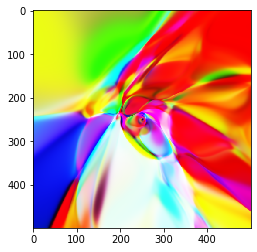

In [21]:
cord_scale=10
r_scale=20
z_scale=0.3
colored=True
img = image_gen(sizes, parameters, z, cord_scale, r_scale, z_scale, colored)
# cv2.imshow('image',img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Run the code below to experiment with the different scaling factors and see how they affect the generated pattern. The function generates 125 images with progressively incresing scaling factors and stores them in images list.
##### This may take a while depending on  hardware specification.

In [ ]:
images=[]

for i in range(1,6):
    temp = []
    for j in range(1,6):
        for k in range(1,6):
            img = image_gen(sizes, parameters, z, 0.1*pow(3.33,k), 0.1*pow(3.33, i), 0.1*pow(3.33, j), True)
            temp.append(img)
    
    images.append(temp)
# cv2.imshow('image',img)
# cv2.imwrite('1.png', img)
# cv2.waitKey(4000)
# cv2.destroyAllWindows()

The folowing function is a helper function which shows images in a grid.

In [17]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

When the above code is run, the list 'images' will have 125 images. Running each following 5 cells will display 25 of them at a time in a palette of 5x5 images.
* Each palette has fixed r_scale(which is mentioned above each of them)
* Within the palette z_scale changes progressively going down.
* Within the palette cord_scale changes progressively going right.

Following table can be used to decode z_scale and cord_scale for each image in a palette.
Eg in first palette all images are generated using r_scale=0.3, while, in the palette image at cordinates (2,1)
has z_scale=0.3 and cord_scale=1.

|   cord_scale(right), z_scale(down)    |   0.3   |   1   |   3   |   10   |   30   | 
|-------|-------|-------|-------|-------|-------|
|  0.3  |  img@(1,1)    |   img@(2,1)   |img@(3,1)   | img@(4,1)|img@(5,1)|
|1|img@(1,2)|img@(2,2)|img@(3,2)|img@(4,2)|img@(5,2)|
|3|img@(1,3)|img@(2,3)|img@(3,3)|img@(4,3)|img@(5,3)|
|10|img@(1,4)|img@(2,4)|img@(3,4)|img@(4,4)|img@(5,4)|
|30|img@(1,5)|img@(2,5)|img@(3,5)|img@(4,5)|img@(5,5)

In [ ]:
show_images(images[0], 5, None) ## r_scale for the generated palette=0.3

In [ ]:
show_images(images[1], 5, None) #r_scale for the generated is 1

In [ ]:
show_images(images[2], 5, None)  #r_scale for the generated palette is 3

In [ ]:
show_images(images[3], 5, None) #r_scale for the following palette is 10

In [ ]:
show_images(images[4], 5, None) #r_scale for the following palette is 30

* One can notice that increasing r_scale increses the bias of output towards circular symmetry and the patterns are more circular.
* Increasing z_scale has zoom in kind of effect.
* Increasing cord_scale produces patterns that have less curves and more straight lines(edgy patterns).



### Generating morphing animations

Tweaking z (latent space vector) in the latent space randomly and slowly should generate images/patterns that differ only slightly (since the output pixel value intensity at each cordinate is a continuous function of z). When a lot of such images are generated continuously and played as frames of a video, we get an animation of these abstract patterns morphing into one another smoothly.

Run the following code to store the frames in the list 'samples'.

In [ ]:
samples = []  #list which will contain frames.
z_new = z    #or a new z can be initialized.

cord_scale=10  #this factor can be changed to experiment.
r_scale = 20    #this factor can be changed to experiment.
z_scale = 0.3    #this factor can be changed to experiment.

number_of_frames = 300    #desired number of frames in video.(@30 fps, 2000 frames would make around 1 min video)

k=20
j=100
change=True
beta = 0.1
d_cord_scale= 0.04
dz=0
for i in range(number_of_frames):
    # k-=1
    j-=1
    # if i%20==0: dz = np.random.randn(32,1)*0.05*sigmoid(np.random.randn())
    # if k==0:
#     if i<50 or i>150:
        # k= round(np.random.uniform()*50)
#       dz = np.random.randn(32,1)*z_scale*beta + dz*(1-beta)
        
    if change==True: 
        dz = np.random.randn(32,1)*z_scale*0.1*beta + dz*(1-beta)
    if j==0:
    #   print(cord_scale)
        j= round((np.random.uniform()+1)*50)
        if cord_scale>5 or cord_scale<-5:
            if np.random.uniform()>0.8: change=True
            else:change=False
        else:
            if np.random.uniform()>0.2: change=True
            else:change=False
    
    #   else: d_cord_scale = -0.05*sigmoid(abs(np.random.randn())*2)
    if cord_scale>15 or cord_scale<-15: d_cord_scale= d_cord_scale*-1
    cord_scale +=d_cord_scale
    temp = image_gen(sizes, parameters, z_new, cord_scale, r_scale, z_scale, True)
    samples.append(temp)
    z_new += dz

The following is a helper function which puts the frames together to generate a video.

In [37]:
dpi = 100

def ani_frame(frames):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    im = ax.imshow(cv2.cvtColor(np.random.randn(500,500,3).astype('uint8'), cv2.COLOR_BGR2RGB))
    im.set_clim([0,1])
    fig.set_size_inches([5,5])
    
    def update_img(data):
#         print(data.shape)
        im.set_data(data)
        return im
    def data_gen(frames):
        for frame in frames:
            yield frame
            
    tight_layout()
    
    #legend(loc=0)
    ani = animation.FuncAnimation(fig,update_img,data_gen(frames),interval=200, save_count=len(frames))
    writer = animation.writers['ffmpeg'](fps=30)     #fps can be changed here.
    ani.save('demo.mp4',writer=writer, dpi=dpi)
    return

 Run the following to generate the video. Video will be saved as demo.mp4 in pwd.

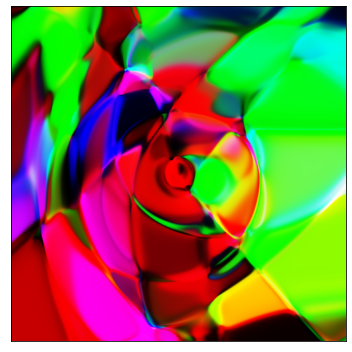

In [38]:
ani_frame(samples)

In [ ]:
##if using google colab.

from google.colab import files
files.download('demo.mp4')